# MPS using the deesse wrapper - simulation paths and additional output maps from deesse

## Main points addressed:
- how to retrieve additional output maps from deesse (simulation path / error / TI grid node index / TI index)
- deesse simulations with different simulation path types

## Import what is required

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os

# import package 'geone'
import geone as gn

In [2]:
# Show version of python and version of geone
import sys 
print(sys.version_info)
print('geone version: ' + gn.__version__)

sys.version_info(major=3, minor=11, micro=5, releaselevel='final', serial=0)
geone version: 1.2.4


## Training image (TI)

In [3]:
# Read file 
data_dir = 'data'
filename = os.path.join(data_dir, 'ti.txt')
ti = gn.img.readImageTxt(filename)

# Values in the TI
ti.get_unique()

array([0., 1., 2.])

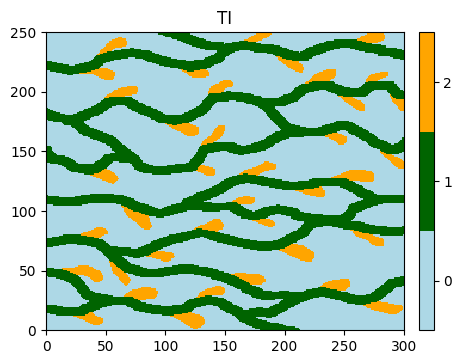

In [4]:
# Setting for categories / colors
categ_val = [0, 1, 2]
categ_col = ['lightblue', 'darkgreen', 'orange']

plt.figure(figsize=(5,5))
gn.imgplot.drawImage2D(ti, categ=True, categVal=categ_val, categCol=categ_col, title='TI')
plt.show()

## Hard data (point set)

In [5]:
# Read the point set
data_dir = 'data'
filename = os.path.join(data_dir, 'hd.txt')
hd = gn.img.readPointSetTxt(filename)
hd

*** PointSet object ***
name = ''
npt = 7 # number of point(s)
nv = 4  # number of variable(s) (including coordinates)
varname = ['X', 'Y', 'Z', 'code']
val: (4, 7)-array
*****

In [6]:
# For further plots:
# Get colors for hard data (according to variable of index 3 in the point set, and color settings)
hd_col = gn.imgplot.get_colors_from_values(hd.val[3], categ=True, categVal=categ_val, categCol=categ_col) 
# # or equivalently:
# import matplotlib.colors
# hd_col=[matplotlib.colors.to_rgba(categ_col[int(v)]) for v in hd.val[3]] # colors (converted to 'rgba') 
#                                                                          # of hard data points

## Getting additional output from deesse (class `geone.deesseinterface.DeesseInput`)

Additional information consisting of output maps (whose support is the simulation grid) can be retrieved in output when running deesse.

### Simulation path map
It consists of an index attached to each simulation grid cell. The indexes give the order in which the cells are simulated.

### Error map
It consists of the (relative) error attached to each simulation grid cell. The error is zero if the acceptation threshold has been reached, and positive otherwise. The error map highlights the regions where the simulation has been done without reaching the threshold and then where the reproduction of the structures might be poor.

### TI grid node index map
It consists of an index attached to each simulation grid cell. The indexes give the index of the grid cell in the TI of the retained candidate during the simulation. The TI grid node index map can be useful for highlighting the regions in the simulation corresponding to *verbatim copy* of the TI.

### TI index map
It consists of an index attached to each simulation grid cell. The indexes give the index of the TI that has been scanned during the simulation. Retrieving this map makes sense only if the number of TIs used is greater than one.

**Remark**
In any of these maps, the value `nan` is set for cells that are not simulated, *i.e* conditioning cells or masked cells.

### Filling the input structure for deesse and launch deesse
To get such maps in output, set corresponding flags (keyword arguments) to `True`:
- simulation path map: flag `outputPathIndexFlag`
- error map: flag `outputErrorFlag`
- TI grid node index map: flag `outputTiGridNodeIndexFlag`
- TI index map: flag `outputTiIndexFlag`

Note that, by default, these flags are set to `False`.

In [7]:
deesse_input = gn.deesseinterface.DeesseInput(
    nx=100, ny=100, nz=1,
    nv=1, varname='code',
    TI=ti,
    dataPointSet=hd,
    outputPathIndexFlag=True,       # get simulation path map in output (default: False)
    outputErrorFlag=True,           # get error map in output (default: False)
    outputTiGridNodeIndexFlag=True, # get TI grid node index map in output (default: False)
    distanceType='categorical',
    nneighboringNode=24,
    distanceThreshold=0.02,
    maxScanFraction=0.25,
    npostProcessingPathMax=1,
    seed=444,
    nrealization=1)

# Run deesse
t1 = time.time() # start time
deesse_output = gn.deesseinterface.deesseRun(deesse_input)
t2 = time.time() # end time
print(f'Elapsed time: {t2-t1:.2g} sec')

DeeSse running... [VERSION 3.2 / BUILD NUMBER 20230914 / OpenMP 19 thread(s)]
DeeSse run complete
Elapsed time: 0.91 sec


## Retrieve the results (and display)

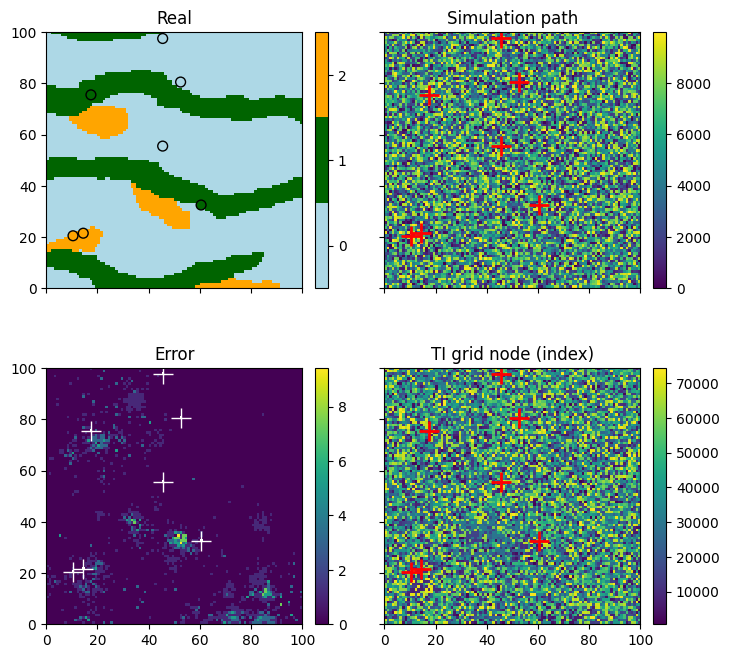

In [8]:
# Retrieve the realizations, the simulation path maps, the error maps and the TI grid node index maps (lists)
sim = deesse_output['sim']
path = deesse_output['path']
err = deesse_output['error']
tiGridNode = deesse_output['tiGridNode']

# Display
plt.subplots(2, 2, figsize=(8,8), sharex=True, sharey=True) # 2 x 2 sub-plots

plt.subplot(2, 2, 1)
gn.imgplot.drawImage2D(sim[0], categ=True, categVal=categ_val, categCol=categ_col, title='Real') # plot real
plt.scatter(hd.x(), hd.y(), marker='o', s=50, color=hd_col, edgecolors='black', lw=1) # add hard data points

plt.subplot(2, 2, 2)
gn.imgplot.drawImage2D(path[0], title='Simulation path') # plot simulation path
plt.plot(hd.x(), hd.y(), '+', markersize=15, c='r', markeredgewidth=2) # add hard data points

plt.subplot(2, 2, 3)
gn.imgplot.drawImage2D(err[0], title='Error') # plot error map
plt.plot(hd.x(), hd.y(), '+', markersize=15, c='white', markeredgewidth=1) # add hard data points

plt.subplot(2, 2, 4)
gn.imgplot.drawImage2D(tiGridNode[0], title='TI grid node (index)') # plot TI grid node index map
plt.plot(hd.x(), hd.y(), '+', markersize=15, c='r', markeredgewidth=2) # add hard data points

plt.show()

## Specifying the simulation path type
Several types of simulation path are available. It is specified by the keyword argument `simPathType` (of the class `geone.deesseinterface.DeesseInput`), which is a character string:
- `random`: random path (default)
- `random_hd_distance_pdf`: random path set according to the distance to the ensemble of conditioning cells based on a probability distribution function (pdf): cells closer to a conditioning cell have a higher probability to be visited in the beginning of the path. It uses the keyword argument `simPathStrength`, a float in between 0 and 1: the closer to 1, more the path will be guided by the conditioning cells. (For unconditional simulation, one cell randomly chosen in the simulation grid will play the role of conditioning cell.)
- `random_hd_distance_sort`: random path set according to the distance to the ensemble of conditioning cells based on sort: the cells are sorted with respect to this distance combined with a random noise. It uses the keyword argument `simPathStrength`, a float in between 0 and 1: the closer to 1, more the path will be guided by the conditioning cells. (For unconditional simulation, one cell randomly chosen in the simulation grid will play the role of conditioning cell.)
- `random_hd_distance_sum_pdf`: random path set according to the sum of distances to the conditioning cells based on pdf. It uses the keyword argument `simPathPower`, a positive float to which the distances are raised before computing the sum, and the keyword argument `simPathStrength`, a float in between 0 and 1: the closer to 1, more the path will be guided by the conditioning cells. (For unconditional simulation, a random path is used.)
- `random_hd_distance_sum_sort`: random path set according to the sum of distances to the conditioning cells based on sort. It uses the keyword argument `simPathPower`, a positive float to which the distances are raised before computing the sum, and the keyword argument `simPathStrength`, a float in between 0 and 1: the closer to 1, more the path will be guided by the conditioning cells. (For unconditional simulation, a random path is used.)
- `unilateral`: unilateral path which uses the keyword argument `simPathUnilateralOrder` defining the order the axes (x, y, z\[, v (variables)\]) will be handled (see the doc by typing `help(gn.deesseinterface.DeesseInput)`.

Some examples are given below.

### Random path according to the distance to hard data point set based on pdf

In [9]:
# path: 'random_hd_distance_pdf', strength: 0.8
deesse_input = gn.deesseinterface.DeesseInput(
    nx=100, ny=100, nz=1,
    nv=1, varname='code',
    TI=ti,
    dataPointSet=hd,
    outputPathIndexFlag=True,
    outputErrorFlag=True,
    outputTiGridNodeIndexFlag=True,
    simPathType='random_hd_distance_pdf',  # set simulation path type
    simPathStrength=0.8,                   #    set parameter for the path
    distanceType='categorical',
    nneighboringNode=24,
    distanceThreshold=0.02,
    maxScanFraction=0.25,
    npostProcessingPathMax=1,
    seed=444,
    nrealization=1)

# Run deesse
t1 = time.time() # start time
deesse_output = gn.deesseinterface.deesseRun(deesse_input)
t2 = time.time() # end time
print(f'Elapsed time: {t2-t1:.2g} sec')

DeeSse running... [VERSION 3.2 / BUILD NUMBER 20230914 / OpenMP 19 thread(s)]
DeeSse run complete
Elapsed time: 0.76 sec


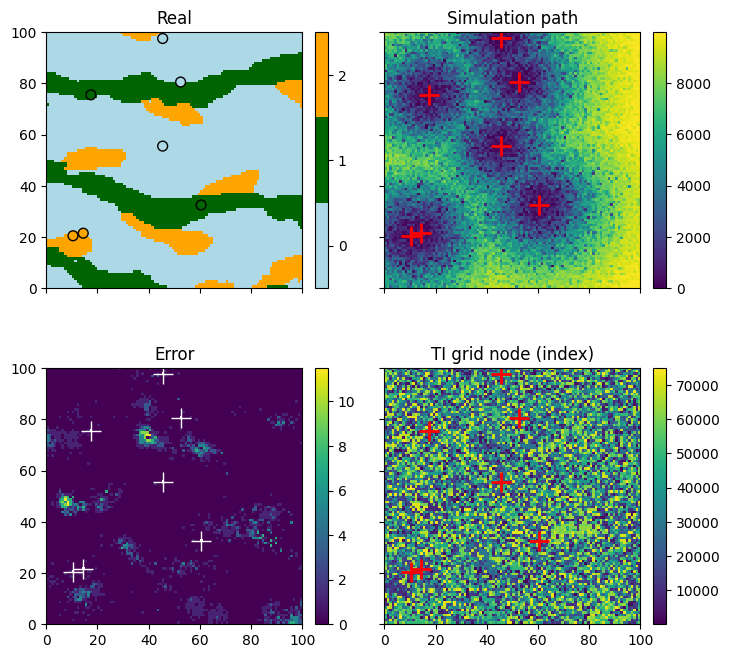

In [10]:
# Retrieve the realizations, the simulation path maps, the error maps and the TI grid node index maps (lists)
sim = deesse_output['sim']
path = deesse_output['path']
err = deesse_output['error']
tiGridNode = deesse_output['tiGridNode']

# Display
plt.subplots(2, 2, figsize=(8,8), sharex=True, sharey=True) # 2 x 2 sub-plots

plt.subplot(2, 2, 1)
gn.imgplot.drawImage2D(sim[0], categ=True, categVal=categ_val, categCol=categ_col, title='Real') # plot real
plt.scatter(hd.x(), hd.y(), marker='o', s=50, color=hd_col, edgecolors='black', lw=1) # add hard data points

plt.subplot(2, 2, 2)
gn.imgplot.drawImage2D(path[0], title='Simulation path') # plot simulation path
plt.plot(hd.x(), hd.y(), '+', markersize=15, c='r', markeredgewidth=2) # add hard data points

plt.subplot(2, 2, 3)
gn.imgplot.drawImage2D(err[0], title='Error') # plot error map
plt.plot(hd.x(), hd.y(), '+', markersize=15, c='white', markeredgewidth=1) # add hard data points

plt.subplot(2, 2, 4)
gn.imgplot.drawImage2D(tiGridNode[0], title='TI grid node (index)') # plot TI grid node index map
plt.plot(hd.x(), hd.y(), '+', markersize=15, c='r', markeredgewidth=2) # add hard data points

plt.show()

### Random path according to the distance to hard data point set based on sort

In [11]:
# path: 'random_hd_distance_sort', strength: 0.5
deesse_input = gn.deesseinterface.DeesseInput(
    nx=100, ny=100, nz=1,
    nv=1, varname='code',
    TI=ti,
    dataPointSet=hd,
    outputPathIndexFlag=True,
    outputErrorFlag=True,
    outputTiGridNodeIndexFlag=True,
    simPathType='random_hd_distance_sort',  # set simulation path type
    simPathStrength=0.5,                    #    set parameter for the path
    distanceType='categorical',
    nneighboringNode=24,
    distanceThreshold=0.02,
    maxScanFraction=0.25,
    npostProcessingPathMax=1,
    seed=444,
    nrealization=1)

# Run deesse
t1 = time.time() # start time
deesse_output = gn.deesseinterface.deesseRun(deesse_input)
t2 = time.time() # end time
print(f'Elapsed time: {t2-t1:.2g} sec')

DeeSse running... [VERSION 3.2 / BUILD NUMBER 20230914 / OpenMP 19 thread(s)]
DeeSse run complete
Elapsed time: 0.34 sec


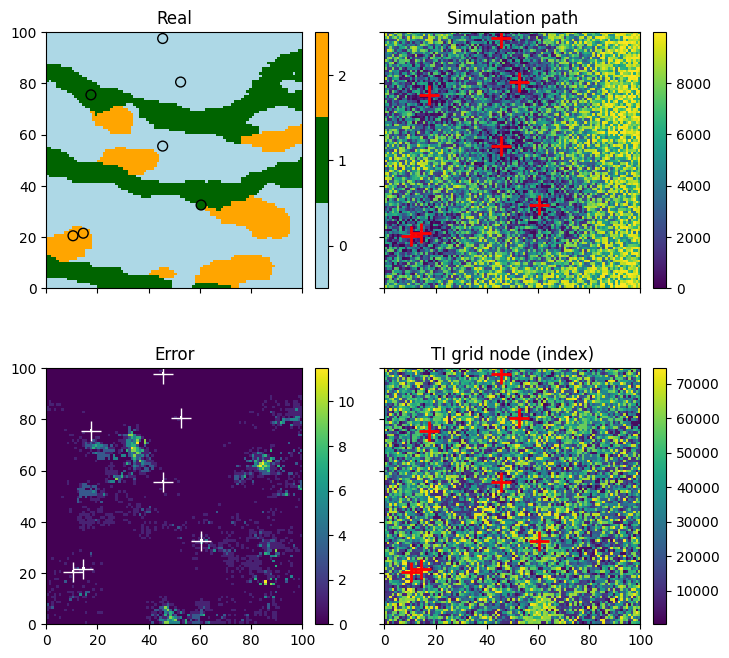

In [12]:
# Retrieve the realizations, the simulation path maps, the error maps and the TI grid node index maps (lists)
sim = deesse_output['sim']
path = deesse_output['path']
err = deesse_output['error']
tiGridNode = deesse_output['tiGridNode']

# Display
plt.subplots(2, 2, figsize=(8,8), sharex=True, sharey=True) # 2 x 2 sub-plots

plt.subplot(2, 2, 1)
gn.imgplot.drawImage2D(sim[0], categ=True, categVal=categ_val, categCol=categ_col, title='Real') # plot real
plt.scatter(hd.x(), hd.y(), marker='o', s=50, color=hd_col, edgecolors='black', lw=1) # add hard data points

plt.subplot(2, 2, 2)
gn.imgplot.drawImage2D(path[0], title='Simulation path') # plot simulation path
plt.plot(hd.x(), hd.y(), '+', markersize=15, c='r', markeredgewidth=2) # add hard data points

plt.subplot(2, 2, 3)
gn.imgplot.drawImage2D(err[0], title='Error') # plot error map
plt.plot(hd.x(), hd.y(), '+', markersize=15, c='white', markeredgewidth=1) # add hard data points

plt.subplot(2, 2, 4)
gn.imgplot.drawImage2D(tiGridNode[0], title='TI grid node (index)') # plot TI grid node index map
plt.plot(hd.x(), hd.y(), '+', markersize=15, c='r', markeredgewidth=2) # add hard data points

plt.show()

### Random path according to the sum of distances to hard data points based on pdf

In [13]:
# path: 'random_hd_distance_sum_pdf', power: 1.0, strength: 0.8
deesse_input = gn.deesseinterface.DeesseInput(
    nx=100, ny=100, nz=1,
    nv=1, varname='code',
    TI=ti,
    dataPointSet=hd,
    outputPathIndexFlag=True,
    outputErrorFlag=True,
    outputTiGridNodeIndexFlag=True,
    simPathType='random_hd_distance_sum_pdf',  # set simulation path type
    simPathPower=1.0,                          #    set parameter for the path
    simPathStrength=0.8,                       #    set parameter for the path
    distanceType='categorical',
    nneighboringNode=24,
    distanceThreshold=0.02,
    maxScanFraction=0.25,
    npostProcessingPathMax=1,
    seed=444,
    nrealization=1)

# Run deesse
t1 = time.time() # start time
deesse_output = gn.deesseinterface.deesseRun(deesse_input)
t2 = time.time() # end time
print(f'Elapsed time: {t2-t1:.2g} sec')

DeeSse running... [VERSION 3.2 / BUILD NUMBER 20230914 / OpenMP 19 thread(s)]
DeeSse run complete
Elapsed time: 0.59 sec


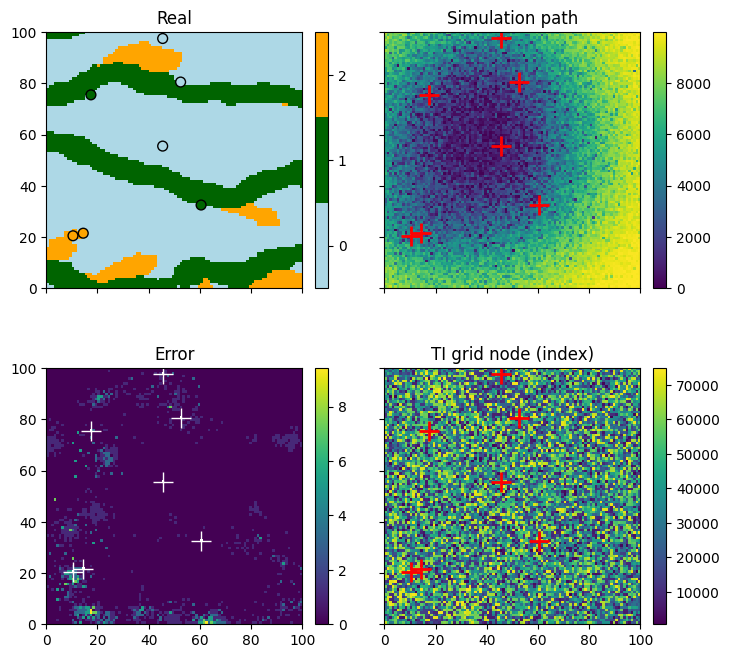

In [14]:
# Retrieve the realizations, the simulation path maps, the error maps and the TI grid node index maps (lists)
sim = deesse_output['sim']
path = deesse_output['path']
err = deesse_output['error']
tiGridNode = deesse_output['tiGridNode']

# Display
plt.subplots(2, 2, figsize=(8,8), sharex=True, sharey=True) # 2 x 2 sub-plots

plt.subplot(2, 2, 1)
gn.imgplot.drawImage2D(sim[0], categ=True, categVal=categ_val, categCol=categ_col, title='Real') # plot real
plt.scatter(hd.x(), hd.y(), marker='o', s=50, color=hd_col, edgecolors='black', lw=1) # add hard data points

plt.subplot(2, 2, 2)
gn.imgplot.drawImage2D(path[0], title='Simulation path') # plot simulation path
plt.plot(hd.x(), hd.y(), '+', markersize=15, c='r', markeredgewidth=2) # add hard data points

plt.subplot(2, 2, 3)
gn.imgplot.drawImage2D(err[0], title='Error') # plot error map
plt.plot(hd.x(), hd.y(), '+', markersize=15, c='white', markeredgewidth=1) # add hard data points

plt.subplot(2, 2, 4)
gn.imgplot.drawImage2D(tiGridNode[0], title='TI grid node (index)') # plot TI grid node index map
plt.plot(hd.x(), hd.y(), '+', markersize=15, c='r', markeredgewidth=2) # add hard data points

plt.show()

### Random path according to the sum of distances to hard data points based on sort

In [15]:
# path: 'random_hd_distance_sum_sort', power: 1.0, strength: 0.5
deesse_input = gn.deesseinterface.DeesseInput(
    nx=100, ny=100, nz=1,
    nv=1, varname='code',
    TI=ti,
    dataPointSet=hd,
    outputPathIndexFlag=True,
    outputErrorFlag=True,
    outputTiGridNodeIndexFlag=True,
    simPathType='random_hd_distance_sum_sort', # set simulation path type
    simPathPower=1.0,                          #    set parameter for the path
    simPathStrength=0.5,                       #    set parameter for the path
    distanceType='categorical',
    nneighboringNode=24,
    distanceThreshold=0.02,
    maxScanFraction=0.25,
    npostProcessingPathMax=1,
    seed=555,
    nrealization=1)

# Run deesse
t1 = time.time() # start time
deesse_output = gn.deesseinterface.deesseRun(deesse_input)
t2 = time.time() # end time
print(f'Elapsed time: {t2-t1:.2g} sec')

DeeSse running... [VERSION 3.2 / BUILD NUMBER 20230914 / OpenMP 19 thread(s)]
DeeSse run complete
Elapsed time: 0.18 sec


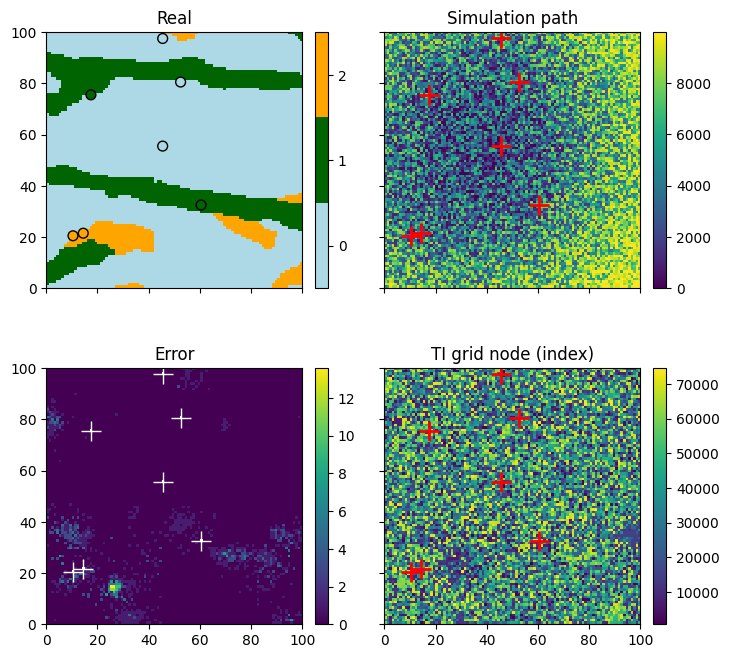

In [16]:
# Retrieve the realizations, the simulation path maps, the error maps and the TI grid node index maps (lists)
sim = deesse_output['sim']
path = deesse_output['path']
err = deesse_output['error']
tiGridNode = deesse_output['tiGridNode']

# Display
plt.subplots(2, 2, figsize=(8,8), sharex=True, sharey=True) # 2 x 2 sub-plots

plt.subplot(2, 2, 1)
gn.imgplot.drawImage2D(sim[0], categ=True, categVal=categ_val, categCol=categ_col, title='Real') # plot real
plt.scatter(hd.x(), hd.y(), marker='o', s=50, color=hd_col, edgecolors='black', lw=1) # add hard data points

plt.subplot(2, 2, 2)
gn.imgplot.drawImage2D(path[0], title='Simulation path') # plot simulation path
plt.plot(hd.x(), hd.y(), '+', markersize=15, c='r', markeredgewidth=2) # add hard data points

plt.subplot(2, 2, 3)
gn.imgplot.drawImage2D(err[0], title='Error') # plot error map
plt.plot(hd.x(), hd.y(), '+', markersize=15, c='white', markeredgewidth=1) # add hard data points

plt.subplot(2, 2, 4)
gn.imgplot.drawImage2D(tiGridNode[0], title='TI grid node (index)') # plot TI grid node index map
plt.plot(hd.x(), hd.y(), '+', markersize=15, c='r', markeredgewidth=2) # add hard data points

plt.show()